**Brian Blaylock**
**April 17, 2019**

# Both GOES-16 and GOES17 on the same map
For more details on plotting GOES ABI images in Python, visit the [Unidata Gallery](https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html#sphx-glr-examples-mapping-goes16-truecolor-py) and other notebooks in this [repository](https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/).

GOES files can be downloaded from Amazon S3:
- Amazon page: https://registry.opendata.aws/noaa-goes/
- My download page: http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/generic_AWS_download.cgi?DATASET=noaa-goes16

In [2]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys

import metpy

sys.path.append('../pyBKB_v3')
from BB_GOES.get_GOES import get_GOES_nearesttime

In [3]:
DATE = datetime(2019, 4, 17, 15)

# This functin gets the nearest file name and path on our local disk. 
# You might want to download GOES files from Amazon.
file16 = get_GOES_nearesttime(DATE, product='ABI', satellite=16, verbose=False)
file17 = get_GOES_nearesttime(DATE, product='ABI', satellite=17, verbose=False)

Requested 2019-04-17 15:00:00	satellite: GOES-16	Product: ABI
**************************************************************
!!!WARNING!!! Missing %s directory: %s ('ABI', '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/ABI-L2-MCMIPC/20190417/')
**************************************************************
**************************************************************
!!!WARNING!!! Missing %s directory: %s ('ABI', '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/ABI-L2-MCMIPC/20190417/')
**************************************************************
**************************************************************
!!!WARNING!!! Missing %s directory: %s ('ABI', '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/ABI-L2-MCMIPC/20190417/')
**************************************************************


ValueError: attempt to get argmin of an empty sequence

In [3]:
G16 = xarray.open_dataset(file16) #using metpy for reading satellite or weather data
G17 = xarray.open_dataset(file17)

In [4]:
def make_RGB(C, night_IR=True):
    """
    C        - GOES file opened with xarray
    night_IR - Set nighttime pixels as clean IR channel (channel 13, 10.3 um).
    """
    
    # Load the three channels into appropriate R, G, and B variables
    R = C['CMI_C02'].data
    G = C['CMI_C03'].data
    B = C['CMI_C01'].data

    ######################################################################
    #

    # Apply range limits for each channel. RGB values must be between 0 and 1
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    ######################################################################
    #

    # Apply a gamma correction to the image
    gamma = 2.2
    R = np.power(R, 1/gamma)
    G = np.power(G, 1/gamma)
    B = np.power(B, 1/gamma)

    ######################################################################
    #

    # Calculate the "True" Green
    G_true = 0.45 * R + 0.1 * G + 0.45 * B
    G_true = np.maximum(G_true, 0)
    G_true = np.minimum(G_true, 1)
    
    # The RGB array with the raw veggie band
    RGB_veggie = np.dstack([R, G, B])

    # The RGB array for the true color image
    RGB = np.dstack([R, G_true, B])
    
    if night_IR:
        cleanIR = C['CMI_C13'].data
        # Normalize the channel between a range. e.g. cleanIR =
        # (cleanIR-minimum)/(maximum-minimum)
        cleanIR = (cleanIR-90)/(313-90)

        # Apply range limits for each channel. RGB values must be between 0 and 1
        cleanIR = np.clip(cleanIR, 0, 1)

        # Invert colors so that cold clouds are white
        cleanIR = 1 - cleanIR

        # Lessen the brightness of the coldest clouds so they don't appear so bright
        # when we overlay it on the true color image
        cleanIR = cleanIR/1.4
    
        # Fill RGB where true color is black with IR values.
        RGB = np.dstack([np.maximum(R, cleanIR),
                         np.maximum(G_true, cleanIR),
                         np.maximum(B, cleanIR)])
        
    return RGB

In [5]:
# Make RGB for both GOES16 and GOES17
rgb16 = make_RGB(G16)
rgb17 = make_RGB(G17)

scan_start_16 = datetime.strptime(G16.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
scan_start_17 = datetime.strptime(G17.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

(-0.5, 2499.5, 1499.5, -0.5)

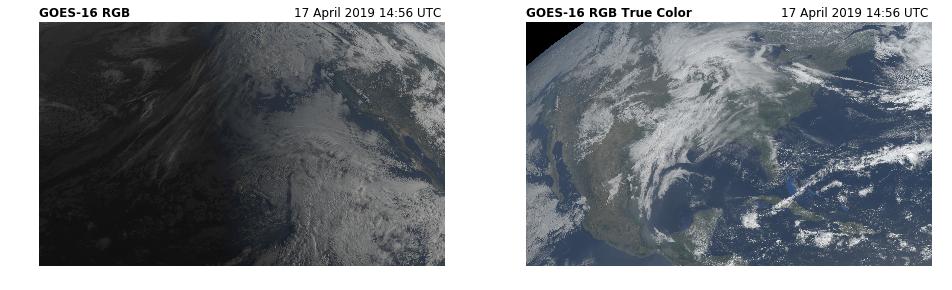

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# The GOES-17 RGB
ax1.imshow(rgb17)
ax1.set_title('GOES-16 RGB', fontweight='semibold', loc='left', fontsize=12);

ax1.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax1.axis('off')

# The GOES-16 RGB
ax2.imshow(rgb16)
ax2.set_title('GOES-16 RGB True Color', fontweight='semibold', loc='left', fontsize=12);
ax2.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax2.axis('off')

In [7]:
# Generate cartopy projection object with metpy parser
# NOTE: Don't re-run this cell after it has run or it won't work.
dat16 = G16.metpy.parse_cf('CMI_C02')
dat17 = G17.metpy.parse_cf('CMI_C02')

# Geostationary projections
geos16 = dat16.metpy.cartopy_crs
geos17 = dat17.metpy.cartopy_crs

In [8]:
x16 = dat16.x
y16 = dat16.y

x17 = dat17.x
y17 = dat17.y

In [9]:
pc = ccrs.PlateCarree()

# Plot Geostationary figures

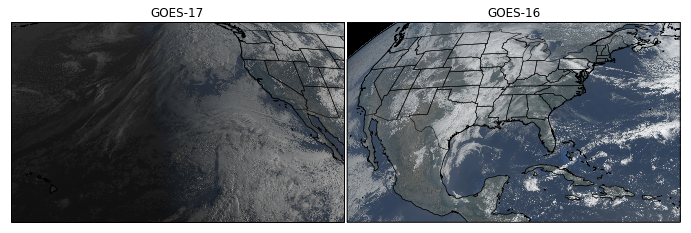

In [10]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1, projection=geos17)
ax2 = fig.add_subplot(1, 2, 2, projection=geos16)


## GOES 17
ax1.imshow(rgb17, origin='upper', extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17)
ax1.coastlines(resolution='50m', color='black', linewidth=.75)
ax1.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax1.set_title('GOES-17')

## GOES 16
ax2.imshow(rgb16, origin='upper', extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16)
ax2.coastlines(resolution='50m', color='black', linewidth=.75)
ax2.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax2.set_title('GOES-16')

fig.subplots_adjust(wspace=.01)

# Lambert Conformal

Transforming the image on the LCC projection takes a long time if you try making the full image size, especially if there is a large area of no data (white space on map).

### Tips for faster plotting:
- **Sacrafice resolution** by downsampling the RGB array `RGB[::20,::20]` would only plot every 20th item. This decreases plotting time significantly and would be useful for quick plots. Simply downscaling in half, i.e. `RGB[::2,::2]`, is more than twice as fast as plotting the full resolution.
- **Zoom** in on an area of interest. For some reason, by zooming into smaller areas, such as a single state, reduces the time it takes to plot. It is best to scale down the image to what you want by showing a smaller domain by with `ax.set_extent()`.

> Setting `interpolation='none'` in `imshow` doesn't seem to do anything.

0:00:07.187179
0:00:07.724066


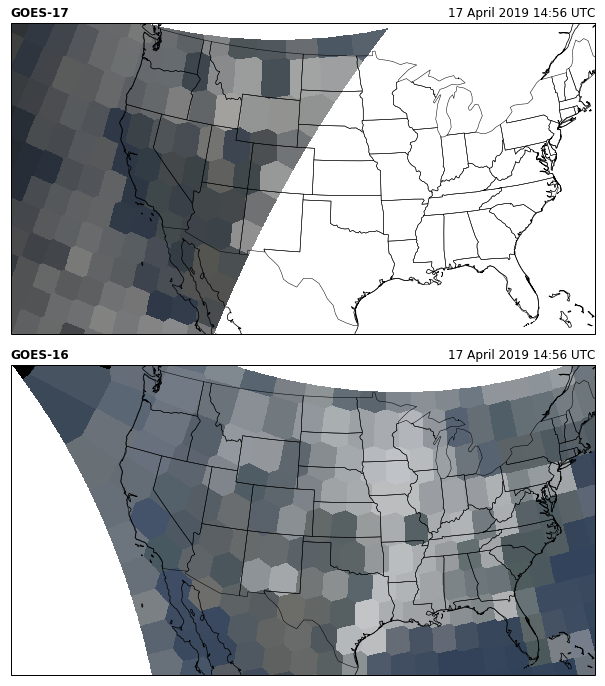

In [11]:
# Downsampling the image makes it faster to plot large areas
thin = 100


fig = plt.figure(figsize=[12, 12])


lc = ccrs.LambertConformal(central_longitude = -97.5,
                           standard_parallels = (38.5, 38.5))

ax1 = fig.add_subplot(2, 1, 1, projection=lc)
ax2 = fig.add_subplot(2, 1, 2, projection=lc)

ax1.set_extent([-130, -75, 25, 48], crs=pc)
ax2.set_extent([-130, -75, 25, 48], crs=pc)

#ax1.set_extent([-155, -70, 20, 45], crs=pc)
#ax1.set_extent([-122.72, -72.29, 24.36, 50.45], crs=pc) # HRRR


# GOES17
timer = datetime.now()
ax1.imshow(rgb17[::thin,::thin], origin='upper',
           extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17, 
           interpolation='none')
print(datetime.now()-timer)
ax1.coastlines(resolution='50m', color='black', linewidth=0.75)
ax1.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
ax1.set_title('GOES-17', loc='left', fontweight='bold')
ax1.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC'), loc='right');


# GOES16
# The imshow transform seems to take a long time
timer = datetime.now()
ax2.imshow(rgb16[::thin,::thin], origin='upper',
           extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16,
           interpolation='none')
print(datetime.now()-timer)

ax2.coastlines(resolution='50m', color='black', linewidth=0.75)
ax2.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
ax2.set_title('GOES-16', loc='left', fontweight='bold')
ax2.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');


fig.subplots_adjust(hspace=.1)

In [1]:
# Downsampling the image makes it faster to plot large areas
thin = 2
print("thin: ", thin)

fig = plt.figure(figsize=[16, 12])


lc = ccrs.LambertConformal(central_longitude = -97.5,
                           standard_parallels = (38.5, 38.5))

ax3 = fig.add_subplot(1, 1, 1, projection=lc)
ax3.set_extent([-130, -75, 25, 48], crs=pc)

# GOES16 + GOES17

# The imshow transform seems to take a long time
timer = datetime.now()
ax3.imshow(rgb16[::thin,::thin], origin='upper',
           extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16,
           interpolation='none')
print(datetime.now()-timer)

timer = datetime.now()
ax3.imshow(rgb17[::thin,::thin], origin='upper',
           extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17,
           interpolation='none')
print(datetime.now()-timer)

ax3.coastlines(resolution='50m', color='black', linewidth=0.75)
ax3.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)

plt.title('GOES-17 Overlaid on GOES-16', fontweight='bold')

thin:  2


NameError: name 'plt' is not defined

# Plate Carree Cylindrical Projection
Zoomed on Utah

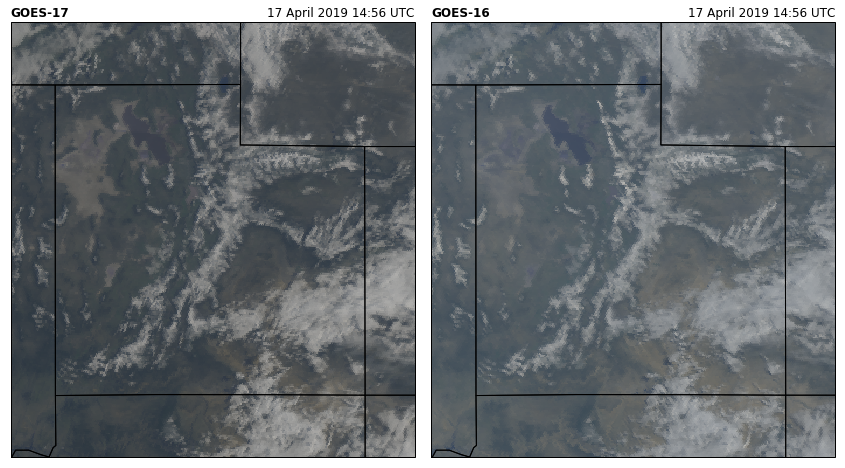

In [13]:
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(1, 2, 1, projection=pc)
ax2 = fig.add_subplot(1, 2, 2, projection=pc)

ax1.set_extent([-114.75, -108.25, 36, 43], crs=pc)
ax2.set_extent([-114.75, -108.25, 36, 43], crs=pc)


# GOES17
ax1.imshow(rgb17, origin='upper',
           extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17,
           interpolation='none')
ax1.add_feature(ccrs.cartopy.feature.STATES)
ax1.set_title('GOES-17', loc='left', fontweight='bold')
ax1.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC'), loc='right');

# GOES16
ax2.imshow(rgb16, origin='upper',
           extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16,
           interpolation='none')
ax2.add_feature(ccrs.cartopy.feature.STATES)
ax2.set_title('GOES-16', loc='left', fontweight='bold')
ax2.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');


fig.subplots_adjust(wspace=.01)